In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from astropy.visualization import ZScaleInterval
import matplotlib

%matplotlib inline

In [2]:
df_ids=wisps.UCD_SPECTRA.grism_id

In [3]:
len(df_ids)

364

In [4]:
df=pd.DataFrame()

In [5]:
df['grism_id']=df_ids.values

In [15]:
s=wisps.Source(filename=df_ids[0], is_ucd=True)

AttributeError: 'NoneType' object has no attribute 'values'

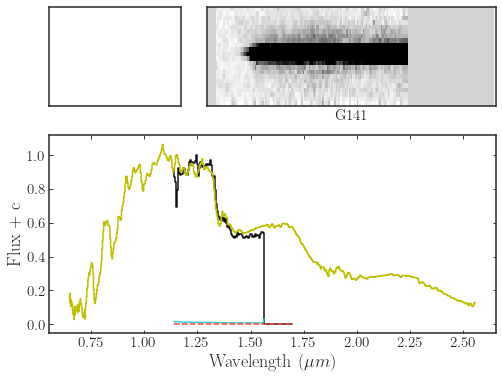

In [16]:
s.plot()

In [8]:
%%capture
df['spectra']=df.grism_id.apply(lambda x: wisps.Source(name=x, is_ucd=True))

In [9]:
df.to_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')

In [10]:
df=pd.read_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')

In [11]:
#remove extra problematic spectra
problems=['cosmos-02-g141_04153', 'cosmos-05-g141_07469']

In [12]:
df=(df[ ~df.grism_id.str.lower().isin(problems)]).reset_index(drop=True)

In [13]:
df['spt']=df['spectra'].apply(lambda x: wisps.make_spt_number(x.spectral_type))

In [14]:
df=df.sort_values(by='spt').reset_index(drop=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
df['distance']=df.spectra.apply(lambda x: x.distance['val'].value)

In [ ]:
df['RA']=df.spectra.apply(lambda x: x.coords.ra.value)
df['DEC']=df.spectra.apply(lambda x: x.coords.dec.value)

In [ ]:
df['snr1']=df.spectra.apply(lambda x: x.snr['snr1'])

In [ ]:
fdf=df[df.spt >=17.]

In [ ]:
len(fdf)

In [ ]:
#distance distributions
from astropy.coordinates import SkyCoord
import astropy.coordinates as astrocoord
import astropy.units as u
coords=SkyCoord(ra=fdf.RA.values*u.deg, dec=fdf.DEC.values*u.deg, distance=fdf.distance.values*u.pc)

In [ ]:
galoc=coords.transform_to(astrocoord.Galactocentric(galcen_distance=8.3*u.kpc))

In [ ]:
#Rsun=8300.
#Zsun=27.
#r=np.sqrt( (coords.distance.value * np.cos( coords.galactic.b.radian ) )**2 + Rsun * (Rsun - 2 * coords.distance.value * np.cos( coords.galactic.b.radian ) * np.cos( coords.galactic.l.radian ) ) )
#z=Zsun+ coords.distance.value * np.sin( coords.galactic.b.radian - np.arctan( Zsun / Rsun) )
x, y, z=galoc.cartesian.xyz
r=(x**2+y**2)**0.5

In [ ]:
fig, (ax, ax1)=plt.subplots(figsize=(11, 4), ncols=2)
sc=ax.scatter(r, z, c=fdf.spt.values, s=50, cmap='viridis')
br=plt.colorbar(sc)
#ax.ylabel('z (pc)', fontsize=20)
#ax.xlabel('r (pc)', fontsize=20)
#plt.grid()

ax.minorticks_on()

sc=ax1.scatter(x, y, c=fdf.spt.values, s=50, cmap='viridis')


#plt.grid()
ax.minorticks_on()

ax.set_xlim([6000, 11000])
ax.set_ylim([-5000, 6000])

ax1.set_xlim([-13000, -2500])
ax1.set_ylim([-3000, 3000])

ax.set_ylabel('z (pc)', fontsize=20)
ax.set_xlabel('r (pc)', fontsize=20)
ax1.set_ylabel('x (pc)', fontsize=20)
ax1.set_xlabel('y (pc)', fontsize=20)

ax.minorticks_on()
ax1.minorticks_on()

br.set_ticks([20, 25, 30, 35, 40])
br.set_ticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_distances.pdf', bbox_inches='tight')

In [ ]:
mags=wisps.Annotator.reformat_table(pd.DataFrame.from_records(fdf.spectra.apply(lambda x: x.mags).values))

In [ ]:
#MAKE THIS COLOR ABSOLUTE MAG from your mag relations

In [ ]:
abs_mag_relation_140=wisps.POLYNOMIAL_RELATIONS['sp_F140W']
abs_mag_relation_110=wisps.POLYNOMIAL_RELATIONS['sp_F110W']
abs_mag_relation_160=wisps.POLYNOMIAL_RELATIONS['sp_F160W']

In [ ]:
dhgjk=fdf.sort_values(by='distance')[['grism_id', 'distance', 'spt']]

In [ ]:
latc_df=pd.DataFrame()

In [ ]:
latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper())
latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
latc_df['spt']=fdf.spectra.apply(lambda x: x.spectral_type)
latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
latc_df['f110']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][0], 1))
latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
latc_df['f140']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][0],1))
latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
latc_df['f160']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][0], 1))
latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
latc_df['distance']=fdf.spectra.apply(lambda x: int(round(x.distance['val'].value)))
latc_df['distance_er']=fdf.spectra.apply(lambda x: int(round(x.distance['er'].value)))



In [ ]:
df[df.grism_id=='goodsn-33-G141_09283'].spt.apply(wisps.make_spt_number)>=17

In [ ]:
'goodsn-33-G141_09283'.lower() in latc_df['grism id'].apply(lambda x: x.lower()).values

In [ ]:
latc_df[latc_df.spt=='L4']

In [ ]:
%%capture
fold='/Users/caganze/research/wisps/figures/ltwarfs/'

ids=0
for idx, row in fdf.iterrows():
    s=row.spectra
    
    filename=fold+'spectrum'+str(ids)+'.jpeg'
    s.plot(save=True, filename=filename)
    ids=ids+1


In [ ]:
from astropy.coordinates import SkyCoord

In [ ]:
indices_df=pd.DataFrame.from_records(df.spectra.apply(lambda x: x.indices).values)

In [ ]:
for k in indices_df.columns: df[k]= indices_df[k]

In [ ]:
#df.to_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf', key='with_indices')

In [ ]:
import astropy.units as u

In [ ]:
#latc_df.ra.values*u.deg

In [ ]:
sk=SkyCoord(ra=latc_df.ra.values*u.deg, dec=latc_df.dec.values*u.deg, distance=latc_df.distance.values*u.pc)

In [ ]:
norm = matplotlib.colors.Normalize(vmin=20., vmax=37.0)

In [ ]:
from matplotlib import cm

In [ ]:
import wisps.simulations as wispsim

In [ ]:
df['pointing']=df.grism_id.apply(wispsim.get_proper_pointing)

In [ ]:
pntcoords=SkyCoord([x.coord for x in wisps.OBSERVED_POINTINGS if not x.name in df.pointing.values])

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='mollweide')

ax.scatter(pntcoords.galactic.l.wrap_at(180*u.deg).radian, pntcoords.galactic.b.wrap_at(180*u.deg).radian, c='grey', marker='x', alpha=0.5)
c=ax.scatter(sk.galactic.l.wrap_at(180*u.deg).radian, sk.galactic.b.wrap_at(180*u.deg).radian,
           c=latc_df.spt.values, cmap='viridis')


plt.xlabel("l", fontsize=18)
plt.ylabel("b", fontsize=18)
plt.grid()
#br=plt.colorbar(c, orientation="horizontal")
#br.set_ticks([20, 25, 30, 35, 40])
#br.set_ticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_skymap.pdf', bbox_inches='tight')

In [ ]:
df.columns

In [ ]:
latc_df.to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, na_rep=' ')

In [ ]:
#check that I'm not crazy
stars=wisps.Annotator.reformat_table((wisps.datasets['stars']))
stars['grism_id']=stars.grism_id.apply(lambda x: x.lower())

In [ ]:
sts=pd.concat([stars[stars.grism_id.isin([x.lower()])] for x in df.grism_id.values])

In [ ]:
df=wisps.Annotator.reformat_table(df)

In [ ]:
wisps.INDEX_NAMES

In [ ]:
for x in wisps.INDEX_NAMES:
    
    fig, ax=plt.subplots()
    plt.scatter(df[x], sts[x], c=df.spt)
    plt.plot(df[x], df[x], c='k')

    sm=df[x].replace(np.inf, np.nan).dropna()
    ax.set_xlim([sm.min(), sm.max()])
    ax.set_ylim([sm.min(), sm.max()])

    ax.set_ylabel('From ratios', fontsize=18)
    ax.set_xlabel('From spectrum', fontsize=18)
    plt.minorticks_on()
    ax.set_title(r'$'+str(x.split(' ')[0])+'$', fontsize=18)


In [ ]:
def plot_vals(values, ax, title):
    values=wisps.drop_nan(np.sort(values))
    kernel = stats.gaussian_kde(values)
    height = kernel.pdf(values)
    mode_value = values[np.argmax(height)]
    h=ax.hist(values, bins='auto', normed=True, histtype='step')
    ax.plot(values, height)
    ax.axvline(mode_value, c='k')
    ax.set_xlabel(title, fontsize=18)

In [ ]:
SFDGF

In [ ]:
fig, ax=plt.subplots(ncols=3,figsize=(12, 4))
plot_vals((wisps.OBSERVED_POINTINGS[np.random.randint(533)]).mags['F110'], ax[0], 'F110W')
plot_vals((wisps.OBSERVED_POINTINGS[np.random.randint(533)]).mags['F140'], ax[1], 'F140W')
plot_vals((wisps.OBSERVED_POINTINGS[np.random.randint(533)]).mags['F160'], ax[2], 'F160W')
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limits_illustration.pdf', bbox_inches='tight')